## PHY4268 Tutorial 5 - Geometry optimization

1. **S. G. Nana Engo**, serge.nana-engo@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Yaounde I
2. **J-P. Tchapet Njafa**, jean-pierre.tchapet-njafa@univ-maroua.cm
    * Department of Physics, Faculty of Science, University of Maroua
       
May 2024

L'**optimisation de la structure géométrique** permet d'ajuster la structure géométrique afin déterminer la configuration électronique la plus stable. Celle-ci permet d'obtenir une meilleure concordance entre les calculs théoriques et les mesures expérimentales.  

Dans ce tutoriel, nous allons apprendre à optimiser la structure géométrique des molécules en utilisant 
* [RDKit](https://github.com/rdkit) (Open-Source Cheminformatics Software);
* [xTB](https://xtb-docs.readthedocs.io/en/latest/) (Semiempirical Extended Tight-Binding Program Package) et [CREST](https://xtb-docs.readthedocs.io/en/latest/) ( Conformer-Rotamer Ensemble Sampling Tool based on the xtb Semiempirical Extended Tight-Binding Program Package).

Il est à noter que le framework xTB permet de
* permettre un accès de bas niveau aux composants formant l'expression énergétique réelle;
* fournir un cadre pour gérer et manipuler les données de paramétrage;
* fournir des fonctionnalités au-delà des calculs à point unique (single-point) dans cette bibliothèque : l'optimisation géométrique et  la dynamique moléculaire.

## Choix des coordonnées

Un concept fondamental en chimie quantique est la surface d’énergie potentielle (PES, potential energy surface) multidimensionnelle. Il capture l'interaction entre les degrés de liberté électroniques et nucléaires dans un système, et les points stationnaires sur le PES sont importants pour élucider les conformations moléculaires et expliquer les mécanismes des réactions chimiques et photochimiques. Les dérivées du premier (**gradient**) et du second ordre (**Hessien**) de l'énergie par rapport aux déplacements nucléaires sont des éléments clés pour localiser ces points (minima et états de transition (transition states, TS)) et déterminer les voies de réaction d'énergie minimale.

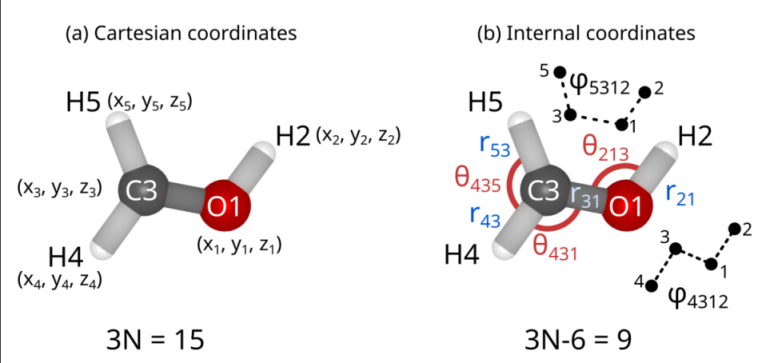

Examinons le choix des coordonnées dans lesquelles ces dérivées énergétiques sont exprimées.

### Coordonnées cartésiennes

La manière la plus simple de définir les positions atomiques consiste à utiliser un système de référence cartésien et à définir chaque position atomique en termes de sa position, (x,y,z)-coordonnées. Dans ce système de coordonnées, il est très facile de déterminer l'énergie totale et le gradient d'énergie, mais ce choix n'est pas favorable à l'optimisation géométrique, car ces coordonnées sont fortement couplées entre elles.

### Coordonnées internes

Un choix plus avantageux consiste à travailler avec des coordonnées internes, telles que les longueurs de liaison, les angles de valence et les dièdres. L'ensemble de coordonnées internes le plus connu est la **matrice Z**, qui utilise ces propriétés pour décrire la structure moléculaire. Cependant, l'utilisation de coordonnées internes pose deux défis : 
1. le choix des coordonnées n'est pas unique et
2. les coordonnées internes doivent être reconverties en coordonnées cartésiennes pour calculer l'énergie et le gradient. 

## Théorie de l'état de transition

![PES.png](./Graphics/PES.png)

La deuxième classe de points particuliers sur les PES dont nous discutons ici sont les états de transition. Ceux-ci sont importants pour expliquer les mécanismes des réactions chimiques et photochimiques. Les états de transition sont des points selles (**saddle points**) de premier ordre sur la surface d'énergie potentielle **et sont caractérisés par un gradient nul combiné à un Hessien qui a une et une seule valeur propre négative**. Les optimisations d'état de transition utilisent donc des approches quadratiques, telles que les méthodes de Newton-Raphson et quasi-Newton. L’idée derrière une optimisation d’état de transition est de faire un pas de Newton-Raphson dans la direction opposée au gradient pour chaque valeur propre positive du Hessien et un pas de Newton-Raphson le long du gradient pour la valeur propre négative du Hessien. Cela signifie que dans une coordonnée, l’énergie est maximisée, tandis que dans toutes les autres coordonnées, elle est minimisée. **Cela signifie également que la géométrie initiale doit être similaire à l’état de transition et contenir une valeur négative du Hessien**. La pratique courante consiste donc à effectuer une optimisation contrainte, par exemple en effectuant un balayage détendu des coordonnées d'une coordonnée impliquée dans la réaction. La structure d’énergie la plus élevée peut alors être considérée comme une géométrie initiale raisonnable pour une recherche d’état de transition.

### DFT flowchart

![DFT_Flowchart.jpg](Graphics/DFT_Flowchart.jpg)

Lorsque la molécule est loin de la géométrie d'équilibre, ce serait un gaspillage de ressources computationnelles que d'exécuter des optimisations géométriques directement aux niveaux théoriques de la théorie quantique (tels que DFT ou MP2). Dans ces cas-là, il est très bénéfique d'effectuer d'abord une pré-optimisation de la molécule en utilisant certains méthodes de théorie semi-empirique.

Les méthodes de théorie semi-empiriques sont dérivées des méthodes de théorie quantique et contiennent des approximations supplémentaires. Ces approximations les rendent moins précises mais des ordres de grandeur plus rapides. En d'autres termes, l'optimisation de molécules organiques simples de taille moyenne (telles que certaines molécules pharmaceutiques courantes) **peut durer entre 10 et 60 minutes en utilisant la méthode DFT**, selon la vitesse de votre calculateur. Cependant, optimiser cette molécule **à l'aide d'une méthode semi-empirique ne prendrait que quelques secondes!** Il est très important de mentionner que dans le cas des molécules organiques, les méthodes semi-empiriques modernes fourniront des géométries moléculaires très proches de celles obtenues à des niveaux théoriques plus élevés, tels que DFT ou MP2.

## Optimisation orbitale 

L'optimisation orbitale, souvent simplement appelée optimisation géométrique, optimisation moléculaire ou relaxation, est le processus par lequel la géométrie d'une molécule est ajustée pour trouver une structure avec l'énergie la plus basse possible. Cette structure optimisée correspond typiquement à une configuration stable, soit un **minimum local** (une espèce stable), soit un **état de transition** (une configuration à haute énergie entre deux espèces stables).

En termes pratiques, les ingrédients pour effectuer une optimisation géométrique comprennent : 
1. les coordonnées moléculaires initiales,
2. un choix de système de coordonnées,
3. l'énergie à une géométrie spécifique $E(\mathbf{x})$,
4. le gradient $\mathbf{g}(\mathbf{x})=\nabla E(\mathbf{x})$,
5. le Hessien, et
6. une procédure pour mettre à jour les coordonnées et le Hessian et se déplacer sur la surface d’énergie potentielle vers une énergie plus faible.

### Comment ça marche ?

Les étapes d'une optimisation de la géométrie moléculaire sont illustrées dans la figure ci-dessous.

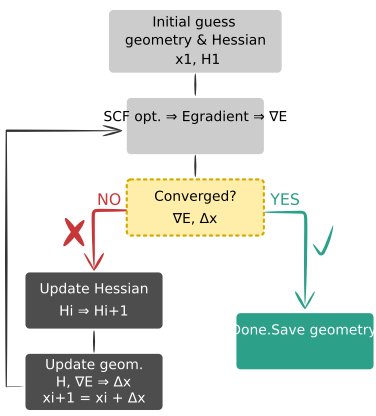

1. **Entrée de géométrie initiale** : l'utilisateur fournit une première estimation de la géométrie moléculaire. Cela peut être basé sur des données expérimentales, une intuition chimique ou des résultats de calculs antérieurs, des applications comme RDKit ou Openbabel.

2. **Choix de la méthode** : Une méthode de théorique quantique (par exemple, méthodes Hartree-Fock, DFT, post-Hartree-Fock) et un ensemble de bases sont choisis en fonction du système et de la précision souhaitée.

3. **Processus itératif** : le programme de structure électronique ajuste de manière itérative les positions des atomes pour réduire l'énergie totale. Ceci est réalisé en calculant les forces exercées sur les atomes et en les utilisant pour prédire une nouvelle géométrie à plus faible énergie.

4. **Convergence** : le processus se poursuit jusqu'à ce que des changements dans la géométrie produisent des changements d'énergie négligeables (critère de convergence satisfait), indiquant qu'une structure optimisée a été trouvée.

Il est important de souligner qu'alors que l’objectif est de trouver le minimum global (la structure énergétique la plus basse absolue), en pratique, l’optimisation géométrique trouve souvent des minima locaux. Des techniques supplémentaires peuvent être nécessaires pour garantir que le minimum global a été localisé.

L'optimisation orbitale dans les méthodes de structure électronique offre les avantages suivants : 
 1. Les énergies deviennent variationnelles en ce qui concerne les rotations orbitales, il n'y a donc pas besoin de réponse orbitale lors du calcul des gradients nucléaires; 
 2. Les propriétés peuvent être calculées plus facilement car il n'y a aucune contribution de réponse orbitale aux matrices de densité; 
 3. Les pôles parasites dans les fonctions de réponse pour des méthodes inexactes telles que la théorie des grappes couplées (coupled cluster ou CC) peuvent être supprimées; 
 4. Les problèmes de rupture de symétrie peuvent être mieux décrits.



## Différentes représentations d'une molécule

La figure ci-dessous présente les différentes représentations d'une molécule. 

![Mol representation](./Graphics/Mol_representation.png)

Dans ce qui suit, nous allons utiliser 

* **XYZ** est une représentation des coordonnées cartésiennes tridimensionnelles des atomes dans une molécule. Dans un fichier XYZ, chaque ligne représente un atome et contient les informations sur l'élément chimique de l'atome ainsi que ses coordonnées x, y et z;

* **SMILES**, Simplified Molecular Input Line Entry System, qui est une notation linéaire utilisée pour décrire la structure chimique des molécules de manière textuelle. Il s'agit d'une chaîne de caractères qui représente les atomes, les liaisons et les groupes fonctionnels d'une molécule. Les SMILES sont compacts et faciles à lire et à écrire. Par exemple, la molécule d'eau (H2O) peut être représentée en SMILES par "O", où "O" représente l'atome d'oxygène et les atomes d'hydrogène sont implicites.

Comme PySCF n'utilise pas directement la représentation SMILES, nous allons utiliser RDKit, la très populaire bibliothèque de chimie informatique.

## Structure géométrique initiale avec RDKit

![RDKit](Graphics/RDKit.png)

 RDKit est une bibliothèque open-source largement utilisée en chimie computationnelle et en chimie médicinale. Elle fournit des outils et des fonctionnalités pour la manipulation, la représentation et l'analyse des molécules.


In [ ]:
try:
    import rdkit
except:
    %pip install rdkit -U
    import rdkit

rdkit.__version__

In [ ]:
from rdkit import Chem
from pathlib import Path # To define path

### Visualisation 2D

In [ ]:
smile = '[B-]1(n2cccc2C=C3[N+]1=CC=C3)(F)F' # BODIPY or 4,4-difluoro-4-bora-3a,4a-diaza-s-indacene
smi_key = 'BODIPY'

# Defines a molecule from its SMILES string
mol_rdkit = Chem.MolFromSmiles(smile)
mol_rdkit

### Quelques propriétés physico-chimique

In [ ]:
from rdkit.Chem import Descriptors

print(f'Some molecular properties are :\
      \n Molecular weight={Descriptors.ExactMolWt(mol_rdkit)},\
      \n Average molecular weight={Descriptors.HeavyAtomMolWt(mol_rdkit)},\
      \n Polarity={Descriptors.TPSA(mol_rdkit)},\
      \n Solubility={Descriptors.MolLogP(mol_rdkit)}')

### Structure non optimisée
#### Visualisation 3D 

In [ ]:
 # Verify if the "data2402_{smi_key}" subdirectory exist and if not, create it
working_dir = Path(f'./data2405/{smi_key}')
# Create the output directory if it doesn't exist
working_dir.mkdir(parents=True, exist_ok=True)


In [ ]:
# For 3D plotting
try :
    import py3Dmol
except:
    %pip install py3Dmol
    import py3Dmol
py3Dmol.__version__

In [ ]:
def view3D(mol, label, fmt='mol'):
        """3D vizualisation of mol/xyz file with Py3DMol
        """

        view = py3Dmol.view(width=400, height=400)

        if fmt=='mol':
            view.addModel(Chem.MolToMolBlock(mol), fmt)
            # view.addModel(mol, fmt)
        elif fmt=='xyz':
            view.addModel(mol, fmt)

        view.setStyle({'stick': {}, 'sphere': {'scale': .30}})
        view.addLabel(label, {'position': {'x': -2, 'y': -3, 'z': 0}})

        view.zoomTo()
        view.show()

In [ ]:
from rdkit.Chem import AllChem

# Add explicit Hs
mol_rdkit = Chem.AddHs(mol_rdkit)

# Generates the initial 3D conformation of the molecule
AllChem.EmbedMolecule(mol_rdkit)

# 3D visualization
mol_rdkit0 = mol_rdkit
view3D(mol_rdkit0, f'{smi_key} RDKit Molecule')


#### Calculs HF

In [ ]:
try:
    import pyscf
except:
    %pip install pyscf -U
    import pyscf

pyscf.__version__

In [ ]:
def HF_Calculations (mol_coords):
    """HF calculations

    Args:
        mol_coords (str): xyz coordinates of the molecule

    Returns:
        df_Eies: Pnadas Data frame of results
    """    
    from pyscf import gto, scf 
    from pyscf.data.nist import HARTREE2EV as au2ev 
    import pandas as pd

    mol_pyscf = gto.Mole(
    atom=mol_coords,
    basis = "6-31G",            # Double zeta with 6 Gaussian primitives
    charge=0,
    spin = 0,
    symmetry = True,
    unit = 'Angstrom')

    mf = scf.RHF(mol_pyscf) # Create a PySCF HF mean-field object
    mf.x2c().density_fit() # To speed up calculations
    mf.kernel()

    # get HOMO-LUMO gap in eV
    lumo_idx = mf.mo_occ.tolist().index(0.)
    homo_idx = lumo_idx - 1
    HL_gap = abs(mf.mo_energy[homo_idx] - mf.mo_energy[lumo_idx]) * au2ev

    # Get the SCF summary as a dictionary
    summary_dict = mf.scf_summary

    # Collect data
    energies = [mf.e_tot, summary_dict['nuc'], summary_dict['e1'], summary_dict['e2'], HL_gap]
    Type_energy = ['Total Energy', 'Nuclear Repulsion Energy', 'One-electron Energy', 'Two-electron Energy', 'HL gap (eV)']

    # Create the results dataframe
    df_Eies = pd.DataFrame({"Energy (a.u.)":energies}, index = Type_energy )

    return df_Eies


In [ ]:
# Set various paths for files
path_energies_csv = working_dir / f'{smi_key}.csv'
path_rdkit_xyz = working_dir / f'{smi_key}_rdkit.xyz'

In [ ]:
# Convert RDKit molecule to XYZ format 
mol_xyz0 = Chem.MolToXYZBlock(mol_rdkit)
print(mol_xyz0)

In [ ]:
# Remove the first two lines (number of atoms and empty line) from XYZ data
mol_xyz0 = '\n'.join(mol_xyz0.strip().split('\n')[2:])

# Check that the xyz file is valide for the next step (pyscf.gto)
print(mol_xyz0)

In [ ]:
df0 = HF_Calculations(mol_xyz0)

# Save the HF results dataframe to a file
with open(path_energies_csv, "w") as f:
    f.write(f"\n\nHF calculations of {smi_key} without any optimization \n")
    df0.to_csv(f)
    
df0

### Structure pré-optimisée avec MMFF94 de RDKit
#### Visualisation 3D 

In [ ]:
from rdkit.Chem import AllChem

# Optimizes the 3D conformation of the molecule using MMFF - Merck Molecular Force Field
AllChem.MMFFOptimizeMolecule(mol_rdkit, maxIters=200, mmffVariant="MMFF94s")

#Canonicalize the orientation of the conformation
Chem.rdMolTransforms.CanonicalizeMol(mol_rdkit, normalizeCovar=True, ignoreHs=False)

# 3D visualization
mol_rdkit1 = mol_rdkit
view3D(mol_rdkit1, f'{smi_key} RDKit Molecule MMFF94')


#### Calculs HF 

In [ ]:
# Convert RDKit molecule to XYZ format 
mol_xyz1 = Chem.MolToXYZBlock(mol_rdkit)

# Remove the first two lines (number of atoms and empty line) from XYZ data
mol_xyz1 = '\n'.join(mol_xyz1.strip().split('\n')[2:])

# Check that the xyz file is valide for the next step (pyscf.gto)
print(mol_xyz1)

In [ ]:
df1 = HF_Calculations(mol_xyz1)

# Save the HF results dataframe to a file
with open(path_energies_csv, "a") as f:
    f.write(f"\n\nHF calculations of {smi_key} with RDKit optimization \n")
    df1.to_csv(f)
    
df1

#### Structure à nouveau optimisée avec xTB et CREST

Il est possible d'exécuter xTB en ligne, sur [atomistica](https://atomistica-online-xtb.anvil.app/).

In [ ]:
try:
  import xtb, crest
except:
  %pip install xtb crest -U
  import xtb, crest

xtb.__version__

In [ ]:
!crest --version


#### Processus d'optimisation semi-empirique

In [ ]:
import subprocess as sp # pour exécuter les processus externes (ici xtb et crest)

# Setting various paths for xtb files
path_xtb_xyz = working_dir / f'{smi_key}_opt.xyz'
path_xtb_log = working_dir / f'{smi_key}_opt.log'

In [ ]:
# Convert RDKit molecule to XYZ format
mol_rdkit_xyz = Chem.MolToXYZBlock(mol_rdkit)
with open("mol_rdkit.xyz", "w") as f:
    f.write(mol_rdkit_xyz)

* Geometry pre-optimization using GFn-XTB with different parameters

In [ ]:
%%bash
# sp.run(["xtb","mol_rdkit.xyz", "--gfn 2 --opt vtight", "--parallel 4"], 
#         stdout=sp.PIPE, stderr=sp.PIPE, text=True, universal_newlines=True)
xtb mol_rdkit.xyz --gfn 2 --opt vtight --parallel 4

* Best conformation search with CREST

In [ ]:
%%bash
# sp.run(['crest', 'xtbopt.xyz', '-gff -mquick --noreftopo'], stdout=sp.DEVNULL, stderr=sp.DEVNULL)
crest xtbopt.xyz -gff -mquick --noreftopo

* xtb geometry optimization of the crest best conformation

In [ ]:
%%bash
# xtb_process = sp.run(["xtb", 'crest_best.xyz', "--gfn 2 --opt vtight", "--parallel 4"],
#                     stdout=sp.PIPE, stderr=sp.PIPE, text=True, universal_newlines=True)
xtb crest_best.xyz --gfn 2 --opt vtight --parallel 4 > xtbopt2.out

In [ ]:

# Store various files 
sp.run(['cp', 'xtbopt.xyz', path_xtb_xyz], stdout=sp.DEVNULL, stderr=sp.DEVNULL)
sp.run(['mv', 'xtbopt2.out', path_xtb_log], stdout=sp.DEVNULL, stderr=sp.DEVNULL)
sp.run(['mv', 'mol_rdkit.xyz', path_rdkit_xyz], stdout=sp.DEVNULL, stderr=sp.DEVNULL)


In [ ]:
# Check the output of xTB_process
print(path_xtb_log.read_text())

#### Gap HOMO-LUMO et énergie totale

Nous allons rechercher les valeurs du gap HOMO-LUMO et de l'énergie totale dans le fichier de sortie (path_xtb_log).

In [ ]:
#---------------------------------------------------------------------
# Extract the total energy and Homo-lumo gap from the xtb output file
#---------------------------------------------------------------------
# Find TOTAL ENERGY value
tot_energy_line = [li for li in path_xtb_log.read_text().splitlines() if 'TOTAL ENERGY' in li]
tot_energy_line = tot_energy_line[0].split()
tot_energy_xtb = float(tot_energy_line[3])

# Find HOMO-LUMO GAP value
HL_gap_line = [li for li in path_xtb_log.read_text().splitlines() if 'HOMO-LUMO GAP' in li]
HL_gap_line = HL_gap_line[0].split()
HL_gap_xtb = float(HL_gap_line[3])

# Find HOMO index
Homo_idx_line = [li for li in path_xtb_log.read_text().splitlines() if '(HOMO)' in li]
Homo_idx_line = Homo_idx_line[0].split()
Homo_idx_xtb = int(Homo_idx_line[0])

# Find LUMO index
Lumo_idx_line = [li for li in path_xtb_log.read_text().splitlines() if '(LUMO)' in li]
Lumo_idx_line = Lumo_idx_line[0].split()
Lumo_idx_xtb = int(Lumo_idx_line[0])

In [ ]:
import pandas as pd

# Create the xtb results dataframe
df_xtb = pd.DataFrame({'xtb calc':[HL_gap_xtb, tot_energy_xtb, Homo_idx_xtb, Lumo_idx_xtb]}, 
index=["HOMO-LUMO GAP (eV)","TOTAL ENERGY (a.u.)", "HOMO Index", "LUMO Index"])

# Save the xtb results dataframe to a file
with open(path_energies_csv, "w") as f:
    f.write(f"\n\nxtb calculations of {smi_key}  \n")
    df_xtb.to_csv(f)
    
df_xtb

In [ ]:
sp.run(['rm', 'bondlengths', 'charges', 'coord', 'coord.original', 'cregen_0.tmp', 'cregen_1.tmp', 'xtbopt2.out',
        'cre_members', 'crest_best.xyz', 'crest_conformers.xyz', 'crest.energies', 'crest_rotamers.xyz', 
        'gfnff_charges', 'gfnff_topo', '.history.xyz', 'struc.xyz', 'wbo','xtbopt.xyz', 'xtbopt.log', '.xtboptok', 
        'xtbrestart', 'xtbtopo.mol', 'xtblast.xyz', 'gfnff_adjacency'], stdout=sp.DEVNULL, stderr=sp.DEVNULL)

#### Visualisation 3D

In [ ]:
# Read the XYZ file
mol_xtb_xyz = path_xtb_xyz.read_text()
lines =mol_xtb_xyz.strip().split('\n')
mol_xtb_xyz = '\n'.join(lines[:1] + [''] + lines[2:])

view3D(mol_xtb_xyz, f'{smi_key} xTB Molecule', fmt='xyz')


In [ ]:
# Create the viewer object
viewer = py3Dmol.view(viewergrid=(1, 3), width=300*3, height=250, linked=True)

# Add the molecules to the viewer
viewer.addModel(Chem.MolToMolBlock(mol_rdkit0), 'mol', viewer=(0, 0))
viewer.addModel(Chem.MolToMolBlock(mol_rdkit1), 'mol', viewer=(0, 1))
viewer.addModel(mol_xtb_xyz, "xyz", viewer=(0, 2))

# Set the view style
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
viewer.setViewStyle({"style": "outline", "width": 0.05})

# Add legends for each molecule
viewer.addLabel('RDKit Molecule', {'position': {'x': -2, 'y': -3, 'z': 0}}, viewer=(0, 0))
viewer.addLabel('RDKit Molecule MMFF94', {'position': {'x': -4, 'y': -3, 'z': 0}}, viewer=(0, 1))
viewer.addLabel('xTB Molecule', {'position': {'x': -2, 'y': -3, 'z': 0}}, viewer=(0, 2))

# Adjust the zoom level
viewer.zoomTo()

# Display the viewer
viewer.show()


#### Calculs HF avec la structure optimisée avec xTB

In [ ]:
# Convert mol_rdkit object to Pyscf Mol objects
mol_xyz3 = '\n'.join(mol_xtb_xyz.strip().split('\n')[2:])

# Check that the xyz file is valide for the next step (pyscf.gto)
print(mol_xyz3)

In [ ]:
df3 = HF_Calculations(mol_xyz3)

# Save the HF results dataframe to a file
with open(path_energies_csv, "a") as f:
    f.write(f"\n\nHF calculations of {smi_key} with xTB optimization \n")
    df3.to_csv(f)
    
df3

### Synthèse des resultats HF

In [ ]:
# Concatenate the DataFrames
result = pd.concat([df0, df1, df3], axis=1)

# Display the concatenated DataFrame
result